# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 5 ноября 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 5 ноября, -4 балла после 06:00 12 ноября, -6 баллов после 06:00 19 ноября  -8 баллов после 06:00 26 ноября.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 2] Фамилия Имя.<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.utils

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$$ w_{new} = (1 - \frac{2\alpha}{c})w_{old} + \frac{2\alpha}{n} \sum_{i = 1}^n ((y_{i} - <x_{i},w_{old}>)x_{i})  $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ w_{new} = (1 - \frac{2\alpha}{c})w_{old} + \frac{\alpha}{n} \sum_{i = 1}^n (x_{i}  (y_{i} -\sigma(w_{old},x)))  $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

* Найдем Гессиан $$ \nabla_{w}^2 Q(w) = 2X^TX $$

Нам необходимо показать, что Гессиан положительно-определенная матрица, запишем определение положительно-определенной матрицы для нашего Гессиана

$$ z^TX^TXz > 0, \forall z \in R^n $$

В последнем выражении у нас записана норма вектора $Xz$, значит он не меньше 0. Если матрица $X$ имеет строк не меньше, чем столбцов и имеет полный ранг, то норма не равна нулю, значит наш Гессиан положительно определен, следовательно  $w = (X^TX)^{-1}X^TY $ является минимумом




*                $ w = (CE + X^{T}X)^{-1}X^{T}y,$   где С  - константа и не равна нулю

При наличии в матрице X линейной зависимых строк, матрица $ X^{T}X $
также будет иметь линейно зависимые строки, а при добавлении L2 регуляризации, все строки будут линейно независимыми

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

Найдем производную $E(L | x_i)$ по $a(x_i)$, приравняем к нулю и сможем найти минимум мат. ожидания

$$\frac{\partial E(L | x_i)}{\partial a} = \frac{a(x_i) - p(y_i = 1 | x_i)}{a(x_i)(1 - a(x_i))} = 0$$

Из данного выражения следует, что значение $a(x_i) = p(y_i = 1 | x_i)$ минимизирует мат. ожидание LogLoss

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Нет, т.к. у нас регуляризатор уменьшает значения наших весов, если мы будем учитывать $w_0$ в регуляризации, то будем иметь в виду, что наше решение находится близко к нулю, что странно. Ну и также $w_0$ не связан с каким-либо, изменяющимся признаком, значит он не влияет на переобучение.

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [403]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    if shuffle:
        X_batch, y_batch = sklearn.utils.shuffle(X, y)
    count = len(y_batch) // batch_size
    for i in range(count):
        X_batch_tmp = X_batch[batch_size * i:batch_size * (i + 1), :]
        y_batch_tmp = y_batch[batch_size * i:batch_size * (i + 1)]
        yield (X_batch_tmp, y_batch_tmp)
    if batch_size * count != len(y_batch):
        X_batch_tmp = X_batch[batch_size * count:, :]
        y_batch_tmp = y_batch[batch_size * count:]
        yield (X_batch_tmp, y_batch_tmp)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [561]:
# %%pycodestyle


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    # Your code Here
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        reg_part = np.dot(self.weights, self.weights) / self.C
        scal_mul = np.dot(X_batch, self.weights)

        if self.model_type == 'lin_reg':
            loss_part = np.mean((y_batch - scal_mul) ** 2)
        elif self.model_type == 'log_reg':
            loss_part = -np.mean(y_batch * np.log(sigmoid(scal_mul)) +
                                 (1 - y_batch) * np.log(sigmoid(1 - scal_mul)))
        loss = loss_part + reg_part
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        loss_coeff = 1 / self.batch_size
        scal_mul = np.dot(X_batch, self.weights)
        reg_part = (2 / self.C) * self.weights
        diff_part = np.zeros(X_batch.shape[1])

        if self.model_type == 'lin_reg':
            diff_part = 2 * np.dot(X_batch.T, scal_mul - y_batch)
        elif self.model_type == 'log_reg':
            diff_part = np.dot(X_batch.T, sigmoid(scal_mul) - y_batch)

        loss_grad = loss_coeff * diff_part + reg_part
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    def fit(self, X, y, batch_size):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Нужно инициализровать случайно веса
        self.batch_size = batch_size
        self.weights = np.random.rand(X.shape[1])
        batch_loss_prev = None
        eps = 0.001
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                while True:
                    batch_grad = self.calc_loss_grad(X_batch, y_batch)
                    self.update_weights(batch_grad)
                    # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                    # До градиентного шага или после
                    batch_loss = self.calc_loss(X, y)
                    if batch_loss_prev == None:
                        batch_loss_prev = batch_loss
                    elif (abs(batch_loss_prev - batch_loss) <= eps) or (batch_loss_prev < batch_loss):
                        break;
                    else:
                        batch_loss_prev = batch_loss
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        hyperflat = np.dot(X, self.weights)
        if self.model_type == 'lin_reg':
            y_hat = hyperflat
        elif self.model_type == 'log_reg':
            y_hat = (hyperflat > 0).astype(int)
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat


Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [562]:
def plot_decision_boundary(clf):
    x1 = [-2, 5]
    f_x1 = np.array([clf.weights[2] + clf.weights[0] * x1[0],
                     clf.weights[2] + clf.weights[0] * x1[1]]) / -clf.weights[1]
    ax1.plot(x1, f_x1, label=clf.model_type)
    ax1.legend()
    print('Weights:', clf.weights)
    pass

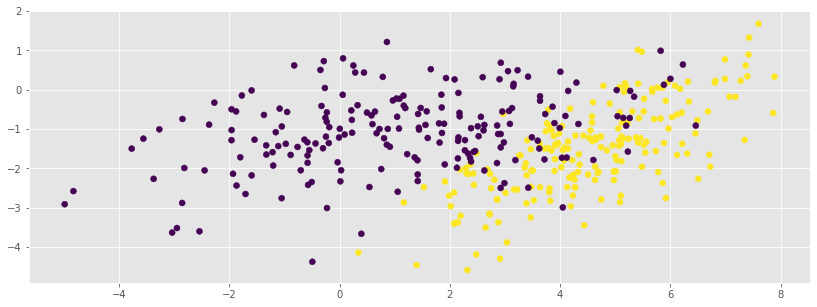

In [563]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(111)

np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
X_new = np.column_stack((X, np.ones(X.shape[0]).reshape(-1, 1)))

ax1.scatter(X[:,0], X[:,1], c=y)

In [564]:
clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=100, C=100)
clf_log.fit(X_new, y, batch_size=5)
plot_decision_boundary(clf_log)

clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, C=100)
clf_lin.fit(X_new, y, batch_size=5)
plot_decision_boundary(clf_lin)

Weights: [ 0.63034819 -0.50412394 -2.28487779]
Weights: [ 0.12732007 -0.16366226 -0.12221305]


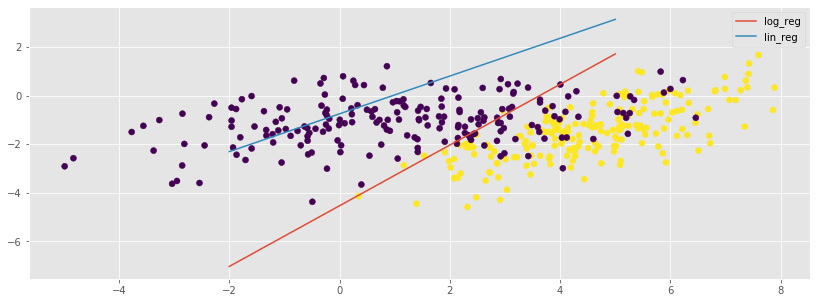

In [565]:
fig

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [566]:
from sklearn.datasets import make_classification

In [567]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [583]:
def pl(clf):
    log = np.array(clf.errors_log['loss'])
    count = len(log) // 50
    x = []
    for i in range(count):
        x.append(np.mean(log[i * 50:(i + 1)*50:]))
    return x

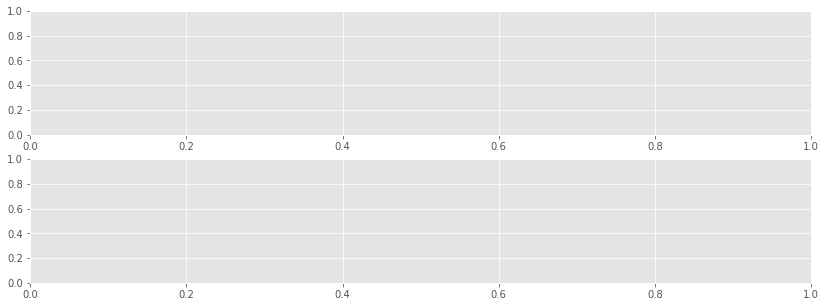

In [584]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

In [585]:
myclf1= MySGDClassifier(batch_generator, model_type='log_reg',
                        max_epoch=10, C=1000)
myclf1.fit(X, y, batch_size=1000)
val = pl(myclf1)
ax1.plot(val, label='0,01')
ax1.legend()

In [586]:
myclf2= MySGDClassifier(batch_generator, model_type='log_reg',
                        max_epoch=10, C=1000, alpha=0.001)
myclf2.fit(X, y, batch_size=1000)
val = pl(myclf2)
ax1.plot(val, label='0,001')
ax1.legend()

In [587]:
myclf3= MySGDClassifier(batch_generator, model_type='log_reg',
                        max_epoch=10, C=1000, alpha=0.1)
myclf3.fit(X, y, batch_size=1000)
val = pl(myclf3)
ax1.plot(val, label='0,1')
ax1.legend()

In [588]:
myclf1= MySGDClassifier(batch_generator, model_type='lin_reg',
                        max_epoch=10, C=1000)
myclf1.fit(X, y, batch_size=1000)
val = pl(myclf1)
ax2.plot(val, label='0,01')
ax2.legend()

In [589]:
myclf2= MySGDClassifier(batch_generator, model_type='lin_reg',
                        max_epoch=10, C=1000, alpha=0.001)
myclf2.fit(X, y, batch_size=1000)
val = pl(myclf2)
ax2.plot(val, label='0,001')
ax2.legend()

In [590]:
myclf3= MySGDClassifier(batch_generator, model_type='lin_reg',
                        max_epoch=10, C=1000, alpha=0.1)
myclf3.fit(X, y, batch_size=1000)
val = pl(myclf3)
ax2.plot(val, label='0,1')
ax2.legend()

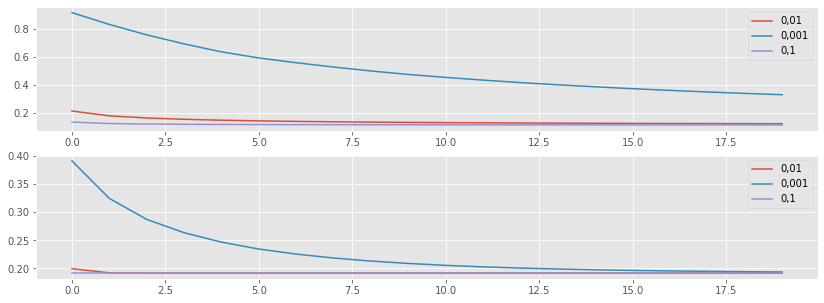

In [591]:
fig

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Можно сказать, что при меньшем alpha сходимость идет менее быстро, для лучшей сходимости стоит выбрать alpha = 0,01

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

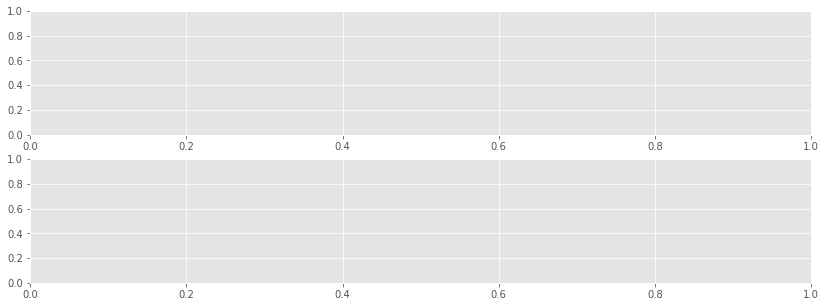

In [568]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

In [ ]:
val = []
for i in np.logspace(3, -3, 10):
    print(i)
    clf_log = MySGDClassifier(batch_generator, model_type='log_reg', max_epoch=10, C=i, alpha=0.01)
    #clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, C=x, alpha=0.1)
    clf_log.fit(X, y, batch_size=1000)
    val.append(np.mean(clf_log.weights))
ax1.plot(val, np.logspace(3, -3, 10))

In [572]:
ax1.plot(np.logspace(3, -3, 10), val)

In [ ]:
val1 = []
for i in np.logspace(3, -3, 10):
    clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=10, C=i, alpha=0.01)
    #clf_lin = MySGDClassifier(batch_generator, model_type='lin_reg', max_epoch=100, C=x, alpha=0.1)
    clf_lin.fit(X, y, batch_size=1000)
    val1.append(np.mean(clf_lin.weights))

In [576]:
ax2.plot(np.logspace(3, -3, 10), val1)

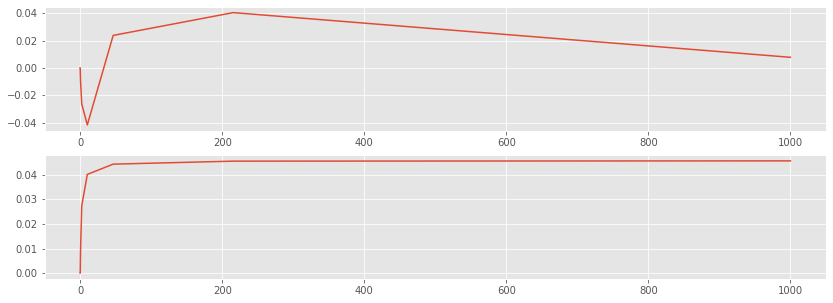

In [577]:
fig

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Веса уменьшелись не очень сильно, т.к. уже были маленькими

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [579]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [580]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [581]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [10]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук прислать Ваш ник на kaggle, под которым Вы залили решение, которое побило первый бейзлайн. **

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***